In [1]:
"Incase you don't have these."
!pip install simclr
!pip install timm
!pip install torchtyping

!gdown --folder https://drive.google.com/drive/folders/1oudus89CoG9_7r3twbIhw2K_pgVr0D0X


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


'Uncomment if you want to use google colab'

In [1]:
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

from simclr.modules.transformations import TransformsSimCLR
from simclr.modules import NT_Xent
from simclr.modules.identity import Identity

from torchtyping import TensorType, patch_typeguard
from torch.utils.data.dataloader import DataLoader
from typing import Callable, Iterator, Dict
from typeguard import typechecked

from matplotlib import pyplot as plt

from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

patch_typeguard()  # use before @typechecked

In [2]:
"For SimCLRv1"
class SimCLR(nn.Module):

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        self.encoder.fc = Identity()
        
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False, device = DEVICE),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False, device = DEVICE),
        )

    def forward(self, x_i, x_j):
        
        
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        
        x_i = self.encoder.conv1(x_i)
        x_i = self.encoder.bn1(x_i)
        x_i = self.encoder.relu(x_i)
        x_i = self.encoder.maxpool(x_i)
        
        #Extract the features from intermediate layers
        h_1 = self.encoder.layer1(x_i)
        h_2 = self.encoder.layer2(h_1)
        h_3 = self.encoder.layer3(h_2)
        h_4 = self.encoder.layer4(h_3)
        
        h_1.norm(dim = 1, p = 2)
        h_2.norm(dim = 1, p = 2)
        h_3.norm(dim = 1, p = 2)
        h_4.norm(dim = 1, p = 2)
        
        return h_i, h_j, z_i, z_j, h_1, h_2, h_3, h_4

In [3]:
image_size = 448
batch_size = 2
projection_dim = 128 #128 for imagenette, 64 for CIFAR10

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
"Code below loads the imagenette data set."
tim_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

imagenet_ds_test = create_dataset(name = '', root = 'imagenetmini', 
                                    transform = tim_transform)

img_testloader = torch.utils.data.DataLoader(
    imagenet_ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

In [7]:
simclr = False #Available strings: 'v1', 'v2', False
#False is going to download a supervised contrastive learning model

if simclr == 'v1':
    !git clone https://github.com/tonylins/simclr-converter.git v1
    !cd v1 && gdown --folder https://drive.google.com/drive/folders/1AlT5YcS1JZFA2JZU2zwoVkdIXFPSnATQ
    !cd v1 && python convert.py ResNet50_2x/model.ckpt-225206 resnet50-2x.pth
    
    from v1.resnet_wider import resnet50x2
    encoder = resnet50x2()
    sd = torch.load('v1/resnet50-2x.pth', map_location=DEVICE)
    encoder.load_state_dict(sd['state_dict'])
    n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
    model = SimCLR(encoder, projection_dim, n_features).to(DEVICE)
    
elif simclr == 'v2':
    !git clone https://github.com/Separius/SimCLRv2-Pytorch.git v2
    !cd v2 && python download.py r50_2x_sk1
    !cd v2 && python convert.py r50_2x_sk1/model.ckpt-250228 --ema
    
    "What the modified resnet.py contains is that it replace the current forward function in the ResNet Class with:"
    "    def forward(self, x, apply_fc=False):"
    "    h = self.net(x).mean(dim=[2, 3]) "
    "    if apply_fc:                     "
    "        h = self.fc(h)               "
            
    "    X = []                           "
    "    for i in self.net:               "
    "        x = i(x)                     "
    "        X.append(x)                  "
      
    "    for i in X:                      "
    "        i.norm(dim = 1, p = 2)       "
            
    "    return h, X[1], X[2], X[3], X[4] "

    #If you are using google colab, there is an issue where gdown cannot retrieve the file.
    #You have to manually download the file by visiting the link and upload the file in the folder 'v2' in colab:
    !cd v2 && gdown https://docs.google.com/uc?id=1yHlXr9xhSBNcEaANDN7_8xFcs_VdOqkX

    "If you are getting an error with the weights, copy the code-snippet above and replace"
    "it in resnet.py."
    
    from v2.resnet import get_resnet
    model, _= get_resnet(50, width_multiplier = 2, sk_ratio = 0.0625)
    pth_path = 'v2/r50_2x_sk1_ema.pth'
    model.load_state_dict(torch.load(pth_path)['resnet'])
    model.to(DEVICE)
else:
    
    !git clone https://github.com/Separius/SimCLRv2-Pytorch.git v2
    !cd v2 && python download.py r50_2x_sk1 --simclr_category=supervised
    !cd v2 && python convert.py r50_2x_sk1/model.ckpt-250228 --supervised    
        
    !cd v2 && gdown https://docs.google.com/uc?id=1yHlXr9xhSBNcEaANDN7_8xFcs_VdOqkX

    "If you are getting an error with the weights, copy the code-snippet above and replace"
    "it in resnet.py."
    
    from v2.resnet import get_resnet
    model, _= get_resnet(50, width_multiplier = 2, sk_ratio = 0.0625)
    pth_path = 'v2/r50_2x_sk1.pth'
    model.load_state_dict(torch.load(pth_path)['resnet'])
    model.to(DEVICE)



fatal: destination path 'v2' already exists and is not an empty directory.

100%|##########| 5/5 [00:00<?, ?it/s]
Downloading...
From: https://docs.google.com/uc?id=1yHlXr9xhSBNcEaANDN7_8xFcs_VdOqkX
To: C:\Users\Shulu\DD2412\DD2412project\v2\resnet.py

  0%|          | 0.00/7.29k [00:00<?, ?B/s]
100%|##########| 7.29k/7.29k [00:00<?, ?B/s]


In [8]:
def inference(loader, simclr_model, device):
    labels_vector = []
    feature_vector_blocks = [[] for i in range(4)]

    for step, (x, y) in enumerate(loader):
        
        x = x.to(DEVICE)

        # get encoding
        
        with torch.no_grad():
            if simclr == 'v1':
                _, _, _, _, h_1, h_2, h_3, h_4 = simclr_model(x, x)
            else:
                _, h_1, h_2, h_3, h_4 = simclr_model(x)

        h_blocks = [h_1, h_2, h_3, h_4]
        for j, i in enumerate(h_blocks):
            i = i.detach()
            feature_vector_blocks[j].extend(i.cpu().detach().numpy())

        labels_vector.extend(y.numpy())

        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
            
        if step == 22:
            break

    labels_vector = np.array(labels_vector)
    
    for i in range(len(feature_vector_blocks)):
        feature_vector_blocks[i] = np.array(feature_vector_blocks[i])
    
    return labels_vector, feature_vector_blocks

def get_features(context_model, test_loader, device):
    test_y, test_blocks = inference(test_loader, context_model, device)
    return test_y, test_blocks 


def create_data_loaders_from_arrays(y_test, block_test, batch_size):
    test1 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[0]), torch.from_numpy(y_test)
    )
    test2 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[1]), torch.from_numpy(y_test)
    )
    
    test3 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[2]), torch.from_numpy(y_test)
    )
    test4 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[3]), torch.from_numpy(y_test)
    )
    
    return test1, test2, test3, test4

In [9]:
print("### Creating features from pre-trained context model ###")
test_y, test_blocks = get_features(model, img_testloader, DEVICE)
block_1, block_2, block_3, block_4 = create_data_loaders_from_arrays(test_y, test_blocks, batch_size)

### Creating features from pre-trained context model ###
Step [0/56]	 Computing features...
Step [20/56]	 Computing features...


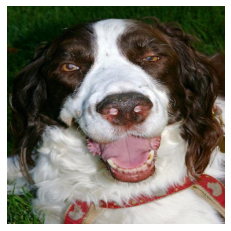

In [10]:
for step, (images, _) in enumerate(imagenet_ds_test):
    if step != 23:
        continue
    batch = images.cpu().detach().numpy()
    batch = np.moveaxis(batch, 0, -1)
    plt.axis('off')
    plt.imshow(batch)
    plt.imsave('dog.jpg', batch)
    break

In [12]:
for step, (images, _) in enumerate(block_1):

    if step != 23:
      continue
    print('images.shape:', images.shape)

    image = images.cpu().detach().numpy()
    image = np.moveaxis(image, 0, -1)
    
    if simclr == 'v1':
        np.save('v1_block1.npy', image)
    elif simclr == 'v2':
        np.save('v2_block1.npy', image)
    else:
        np.save('supervised_block1.npy', image)
        
    break

for step, (images, _) in enumerate(block_2):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    if simclr == 'v1':
        np.save('v1_block2.npy', image)
    elif simclr == 'v2':
        np.save('v2_block2.npy', image)
    else:
        np.save('supervised_block2.npy', image)
    
    break

for step, (images, _) in enumerate(block_3):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    if simclr == 'v1':
        np.save('v1_block3.npy', image)
    elif simclr == 'v2':
        np.save('v2_block3.npy', image)
    else:
        np.save('supervised_block3.npy', image)
    break

for step, (images, _) in enumerate(block_4):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    if simclr == 'v1':
        np.save('v1_block4.npy', image)
    elif simclr == 'v2':
        np.save('v2_block4.npy', image)
    else:
        np.save('supervised_block4.npy', image)

    break

images.shape: torch.Size([512, 112, 112])
images.shape: torch.Size([1024, 56, 56])
images.shape: torch.Size([2048, 28, 28])
images.shape: torch.Size([4096, 14, 14])
